In [1]:
# imports
%tensorflow_version 2.4
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.utils import plot_model
from scipy.stats import linregress

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.4`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
# Preprocesses the training data, trained using IBM minute prices from 1998 until (inclusive) Jan,2021
# downloaded from the free kibot website data sets. The preprocessing ends with three arrays 
# representing the dailypseudo-log return, daily std, and daily linear regression slope

def get_min(date):
  time = (int(date.hour) * 60) + int(date.minute)
  return time - 570

def get_slope(data):
  return linregress(data['MINUTE'].to_numpy(), data['CLOSE'].to_numpy())[0]

def convert_date_train(s):
  return datetime.datetime.strptime(s, "%m/%d/%Y") 

def convert_time_train(s):
  return datetime.datetime.strptime(s, "%H:%M").time() 

df = pd.read_csv("/content/IBM_unadjusted.csv", names=['DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'])
df['DATE'] = df['DATE'].apply(convert_date_train)
df['TIME'] = df['TIME'].apply(convert_time_train)
df = df.loc[df['TIME'] > datetime.time(9,29)]
df = df.loc[df['TIME'] < datetime.time(16,0)]
df['MINUTE'] = df['TIME'].apply(get_min)
df = df.drop(columns=['TIME', 'OPEN','HIGH','LOW','VOLUME'])
df = df.loc[df["DATE"] < datetime.datetime(2021,2,1)]
slope = df.groupby('DATE').apply(get_slope).to_numpy()[1:]
average = df.groupby('DATE').mean()['CLOSE']
plr = np.log(average / average.shift(1)).to_numpy()[1:]
std = df.groupby('DATE').std()['CLOSE'].to_numpy()[1:]

In [4]:
# Preprocesses the test data, tested using IBM minute prices from February 1st,2021 until 
# (inclusive) February 12th,2021 downloaded from the Alpha Vantage website free data sets.
# The preprocessing ends with three arrays representing the dailypseudo-log return, daily std,
# and daily linear regression slope


def convert_date_test(s):
  return datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S').date() 

def convert_time_test(s):
  return datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S').time()

def get_slope(data):
  return linregress(data['min'].to_numpy(), data['close'].to_numpy())[0]

test = pd.read_csv("/content/intraday_1min_IBM_feb1_feb12.csv")
test['date'] = test['timestamp'].apply(convert_date_test)
test['time'] = test['timestamp'].apply(convert_time_test)
test = test.loc[test['time'] > datetime.time(9,29)]
test = test.loc[test['time'] < datetime.time(16,0)]
test['min'] = test['time'].apply(get_min)
test = test.drop(columns=['timestamp', 'open','high','low','volume'])
test_slope = test.groupby('date').apply(get_slope).to_numpy()
test_std = test.groupby('date').std()['close'].to_numpy()
test_avg = test.groupby('date').mean()['close'].to_numpy()
add = df.groupby('DATE').mean()['CLOSE'].to_numpy()[-1]
test_avg = np.insert(test_avg,0,add)
test_plr = np.log(test_avg[1:] / test_avg[:len(test_avg) - 1])

STD: 0.018151196597751638 MEAN: 2.3539368660049865e-05


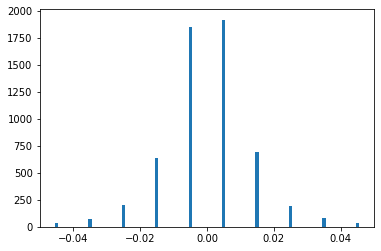

In [11]:
# visualise train data and test data and calculate std and mean for both

print("STD: " + str(np.std(plr)) + " MEAN: " + str(np.mean(plr)))

plt.figure()
plt.hist(plr, range=(-0.05, 0.05), rwidth=0.1)
plt.show()

In [12]:
# creates the training and test data using a sliding windows approach, i.e each sample is the last
# window size fo days from the label

def sliding_window(arr,window_size):
  idx = np.arange(window_size)[None,:] + np.arange(len(arr) - window_size)[:,None]
  return arr[idx]

def create_train_data(plr, slope, std, window_size):
  std_slid = sliding_window(std, window_size)
  plr_slid = sliding_window(plr, window_size)
  slope_slid = sliding_window(slope, window_size)

  X = np.hstack((std_slid,plr_slid,slope_slid))
  y = plr[window_size:,]

  return X,y

def create_test_data(plr, slope, std, test_slope, test_std, test_plr, window_size):
  tplr = np.hstack((plr[-window_size:],test_plr))
  tstd = np.hstack((std[-window_size:],test_std))
  tslope = np.hstack((slope[-window_size:],test_slope))
  std_slid = sliding_window(tstd, window_size)
  plr_slid = sliding_window(tplr, window_size)
  slope_slid = sliding_window(tslope, window_size)

  X = np.hstack((std_slid,plr_slid,slope_slid))

  return X, test_plr

In [13]:
# build and train a DNN  model using the full data set

def build_nn_model(num_layers, input_size):
  input = Input(shape=(input_size))
  for i in range(num_layers):
    if i == 0:
      layer = Dense(input_size, activation='tanh')(input)
    else:
      layer = Dense(math.ceil(input_size * ((num_layers - i) / num_layers)), activation='tanh')(layer)
  out = Dense(1)(layer)
  return Model(inputs=input, outputs=out)

def train_model(X_train, y_train, w_s, num_layers):
  model = build_nn_model(num_layers, 3 * w_s)
  model.compile(loss='mean_squared_error', optimizer=Adadelta(learning_rate=0.005, rho=0.9999, epsilon=1e-10))
  model.fit(X_train, y_train, epochs=100, verbose=0)
  return model

def learn(plr, slope, std, w_s, num_layers):
  X_train, y_train = create_train_data(plr, slope, std, w_s)
  model = train_model(X_train, y_train, w_s, num_layers)
  return model


In [14]:
# predict two weeks ahead and calculate MSE, MAPE and Directional Accuracy of prediction

def predict(model, plr, slope, std, test_slope, test_std, test_plr, window_size):
  X_test, y_test = create_test_data(plr, slope, std, test_slope, test_std, test_plr, window_size)
  return model.predict(X_test).reshape(y_test.shape[0]), y_test

def get_scores(y_test, y_pred):
  mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
  mape = (np.sum((np.abs(y_pred - y_test) / np.maximum(np.abs(y_test), np.finfo(np.float64).eps))) / len(y_test)) * 100
  da = (np.sum((y_test * y_pred) > 0) / len(y_test)) * 100
  return mse, mape, da


In [16]:
# train models with ranges from paper
size = [1,2,3,4,5,6,7,8,9,10,16,32,64,128]
models = [[0 for j in range(10)] for i in range(len(size))]
for i in range(len(size)):
  for j in range(10):
    models[i][j] = learn(plr, slope, std, size[i], j+1)

In [ ]:
# predict from models
predictions = [[0 for j in range(10)] for i in range(len(size))]
y_tests = [[0 for j in range(10)] for i in range(len(size))]
for i in range(len(size)):
  for j in range(10):
    x = predict(models[i][j], plr, slope, std, test_slope, test_std, test_plr, size[i])
    predictions[i][j] = x[0]
    y_tests[i][j] = x[1]

In [19]:
# score predictions, choose top 4 models
mses = [[0 for j in range(10)] for i in range(len(size))]
mapes = [[0 for j in range(10)] for i in range(len(size))]
das = [[0 for j in range(10)] for i in range(len(size))]
for i in range(len(size)):
  for j in range(10):
    scores = get_scores(y_tests[i][j],predictions[i][j])
    mses[i][j] = scores[0]
    mapes[i][j] = scores[1]
    das[i][j] = scores[2]



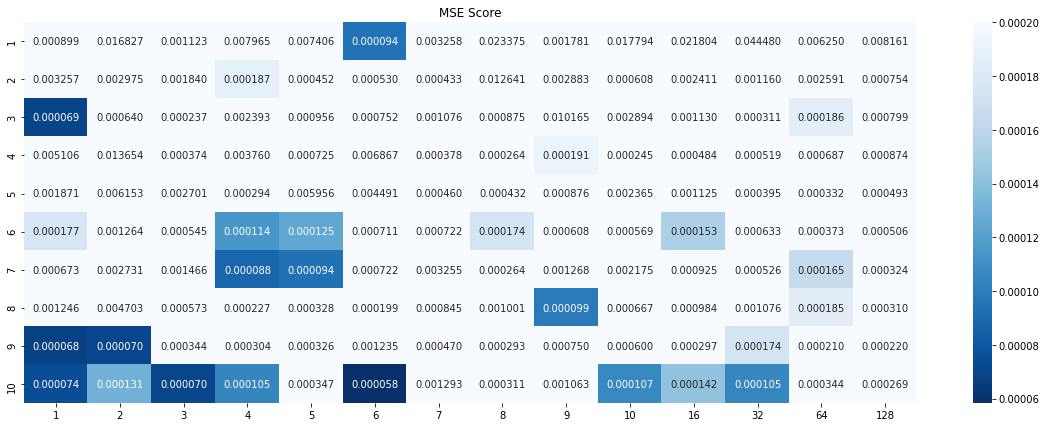

In [58]:
# visualize scores
import seaborn as sns
mses = np.array(mses)
mapes = np.array(mapes)
das = np.array(das)

fig, ax = plt.subplots(figsize=(20,7))
ax.set_title('MSE Score')
ax.set_xticks([])
ax.set_yticks([])
sns.heatmap(mses.T, annot=mses.T, fmt='.6f', ax=ax,xticklabels=size, yticklabels=list(range(1,11)), cmap='Blues_r', vmax=0.0002)
plt.show()


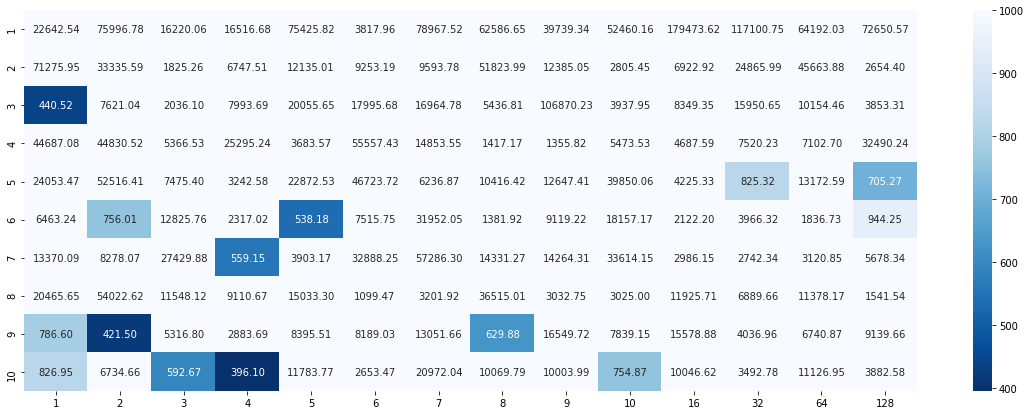

In [62]:
fig, ax = plt.subplots(figsize=(20,7))
title = 'MAPE Score'
plt.title = (title)
ax.set_xticks([])
ax.set_yticks([])
sns.heatmap(mapes.T, annot=mapes.T,fmt='.2f', ax=ax,xticklabels=size, yticklabels=list(range(1,11)), cmap='Blues_r', vmax=1000)
plt.show()

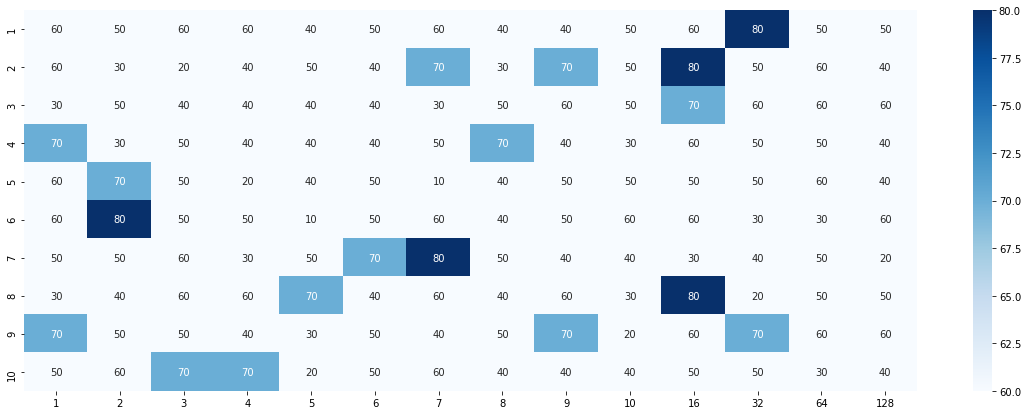

In [64]:
fig, ax = plt.subplots(figsize=(20,7))
title = 'DA Score'
plt.title = (title)
ax.set_xticks([])
ax.set_yticks([])
sns.heatmap(das.T, annot=das.T, ax=ax,xticklabels=size, yticklabels=list(range(1,11)), cmap='Blues', vmin=60)
plt.show()

In [67]:
# calculate the profit of the predicted values using a basic, naive trading strategy.

def to_np(l):
  return np.array(l)

def get_strategy_data(test_data, train_data,  predicted):
  avg = test_data.groupby('date').mean()['close'].to_numpy()
  add = train_data.groupby('DATE').mean()['CLOSE'].to_numpy()[-1]
  avg = np.insert(avg,0,add)
  pred_avg = np.exp(predicted) * avg[:len(avg)-1]
  pred_avg = np.insert(pred_avg,0,0)
  prices = test_data.groupby('date').agg({'close':lambda x: list(x)})['close'].apply(to_np)
  last_close_price = train_data.groupby('DATE').agg({'CLOSE':lambda x: list(x)})['CLOSE'].apply(to_np)[-1][-1]
  return pred_avg, prices.to_numpy(), last_close_price

def daily_strategy(predicted, daily_prices, last_price):
  profit = 0
  if predicted > last_price:
      profit -= last_price
      reached = np.argwhere(predicted <= daily_prices)
      if len(reached) > 0:
          profit += daily_prices[reached[0][0]]
      else:
          profit += daily_prices[-1]
  elif predicted < last_price:
      profit += last_price
      reached = np.argwhere(predicted >= daily_prices)
      if len(reached) > 0:
          profit -= daily_prices[reached[0][0]]
      else:
          profit -= daily_prices[-1]
  return profit

def calculate_profit(test_data, train_data, predicted):
  predicted_avg, prices, last_close_price = get_strategy_data(test_data, train_data, predicted)

  profit = 0
  profit += daily_strategy(predicted_avg[1], prices[0], last_close_price)
  for i in range(2, len(predicted_avg)):
      profit += daily_strategy(predicted_avg[i], prices[i-1], prices[i-2][-1])

  return profit

In [68]:
# run strategy for top 4 selected models
top_4 = [(1,9), (2,6), (3,10), (4,10)]
for i,j in top_4:
  profit = calculate_profit(test, df, predictions[i-1][j-1])
  print("Model with Window Size: {0} and Number of Layers: {1} made a PROFIT of {2}$ in two weeks.".format(i,j,profit))
  print('-----------------------------------------------------------------------------------------')

Model with Window Size: 1 and Number of Layers: 9 made a PROFIT of 8.244999999999976$ in two weeks.
-----------------------------------------------------------------------------------------
Model with Window Size: 2 and Number of Layers: 6 made a PROFIT of 4.264899999999997$ in two weeks.
-----------------------------------------------------------------------------------------
Model with Window Size: 3 and Number of Layers: 10 made a PROFIT of 8.553299999999965$ in two weeks.
-----------------------------------------------------------------------------------------
Model with Window Size: 4 and Number of Layers: 10 made a PROFIT of 9.569999999999965$ in two weeks.
-----------------------------------------------------------------------------------------
